In [1]:
# download MNIST dataset
from sklearn.datasets import fetch_openml
mnist= fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X,y = mnist["data"], mnist["target"] # target means labels
y.shape

(70000,)

In [3]:
X.shape

(70000, 784)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]  # here X means the dataset
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = mpl.cm.binary,interpolation="nearest")
plt.axis("off") # matplotlib imshow() function shows the figure
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
y[0]  # y means the labels,labels means it shows the perfect output

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

In [8]:
y_train_5 = (y_train==5) # True for all 5s, False for all other digits.
y_test_5 = (y_test ==5)
y_train_5

array([ True, False, False, ...,  True, False, False])

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5) # y_train_5 means the target value which's value is 5


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
#implementing cross validation for perfomance measure of classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3,random_state=42)
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold) # checking by test index 
    n_correct = sum(y_pred==y_test_fold) # checking by y_test_folds or test_index of y
    print(n_correct/len(y_pred)) #here cv=3 times,so there three types of answers

0.95035
0.96035
0.9604


In [12]:
# applying k-fold cross validation
from sklearn.model_selection import cross_val_score # cross_val_score defines the SGDclassifier model using k-fold
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy") #here there are 3 answers because the cross validation times are 3 times

array([0.95035, 0.96035, 0.9604 ])

In [13]:
#applying never5classifier
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator): #imagine the images are not 5
    def fit(self,X,y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
#find accuracy of never5classifier
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [15]:
#create a confusion matrix of train set, means making a prediction without seeing the actual output
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [16]:
#see the results of confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred) # here in the output the diagonal value is no 5's=53057 and non 5's


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
#here we don't use the elements of confusion matrix, we just check the total 5's elements
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [19]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [20]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [22]:
y_scores = sgd_clf.decision_function([some_digit]) # using decision function for checking
y_scores # returns a value for one instance

array([2164.22030239])

In [23]:
threshold = 0 #predict a value
y_some_digit_pred = (y_scores > threshold) # checking if the predict value is greater than one instance
y_some_digit_pred

array([ True])

In [24]:
#using predict() method for checking
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

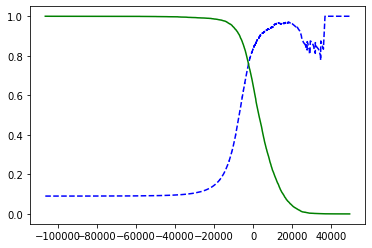

In [25]:
# to decide which threshold to use,return decision scores
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
#now with these scores you can compute precision and recall for all possible thresholds using precision_recall_curve()
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="Precision") # here -1 means decrement by 1
    plt.plot(thresholds, recalls[:-1],"g-",label="recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
# creating 90% precesion,
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)] # find at least 90% precision,so the threshold is lowest
y_train_pred_90 = (y_scores >= threshold_90_precision) #y_score means applying sgd function of some digit and checking precision is 90% 
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [27]:
recall_score(y_train_5,y_train_pred_90) # the higher the precision the lower the recall

0.4799852425751706

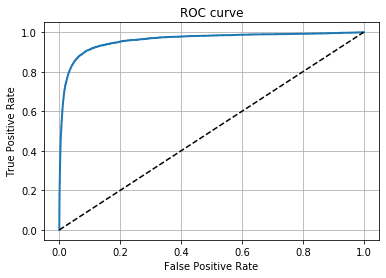

In [28]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores) # finding tpr,fpr for roc 
#plot the FPR against the TPR, applying SGD
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') #dashed diagonal
plot_roc_curve(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.grid()
plt.show()


In [29]:
#compare classifiers is to measure the area under the curve,perfect=1
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

G:\Anaconda installation\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda installation\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda installation\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda installation\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'lower light'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
Th

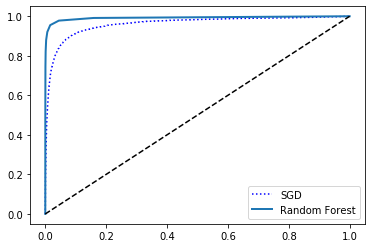

In [30]:
#let's train a RandomForestClassifier and compare its ROC and ROC AUC score to the SGDClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42) #here random state means no matching one state and another state
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba") # find probability
y_scores_forest = y_probas_forest[:,1] # find scores
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr,tpr,"b:",label="SGD") #applyging SGD
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") #applying Random Forest
plt.legend(loc="lower light")
plt.show() #difference between SGD vs Random forest(Random forest is better than SGD)

In [31]:
#this code trains the SGDClassifier on the training set using original target class from 0 to 9,instead of the 5-versus all target clas(y_train_5)
sgd_clf.fit(X_train,y_train) #y_train, not y_train_5(y_train_5 means classification of 5)
sgd_clf.predict([some_digit]) #here predict some digit and finally got some_digit is 3

array([3], dtype=uint8)

In [32]:
#applying decision function,returns 10 scores,one per class
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [33]:
#the highest score indeed the one corresponding to class 3
np.argmax(some_digit_scores) #took some random digit,some digit scores is 3 but some digit is 5

3

In [34]:
sgd_clf.classes_ #total elements of array

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
sgd_clf.classes_[3]

3

In [36]:
#one vs one classifier (using on svm(for heavy))
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42)) #applyinb OvO classifier of a random state
ovo_clf.fit(X_train,y_train) #here X_train is data, and y_train means data's label(0 to 9)
ovo_clf.predict([some_digit]) #"some_digit_scores" is 3 but "some_digit" is 5

array([5], dtype=uint8)

In [37]:
#find the total number of one to one classifier(for the reason 0 to 9 the total no of OvsO classifier is (N*(N-1)/2)=45)
len(ovo_clf.estimators_)

45

In [38]:
#training a RandomForestClassifier 
#forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

G:\Anaconda installation\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [39]:
#did not using OvA,OvO,,using random forest classification
#predict_proba() method to get the list of probabilities that the classifier assigned to each instance for class
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [40]:
#evaluate SGDClassifier's accuracy using the cross_val_score() function
# sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy") #cross validation using for ensure better accuracy
#accuracy is over 84%,

array([0.87082583, 0.87089354, 0.88628294])

In [41]:
#scaling the inputs and increases the accuracy above 89%
#Feature scaling is a method used to normalize the range of independent variables or features of data.
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) #fit_transform calculating the means of coloumns data and transformation to missing values
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

G:\Anaconda installation\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [42]:
#make predictions using the cross_val_predict() function,then call the confusion_matrix()
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_max = confusion_matrix(y_train,y_train_pred)
conf_max #the confusion matrix is when your classification model is confused when it is predicted

G:\Anaconda installation\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

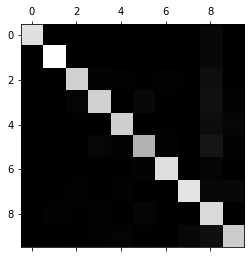

In [43]:
plt.matshow(conf_max,cmap=plt.cm.gray)
plt.show()

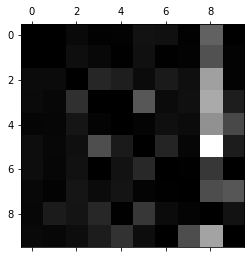

In [44]:
row_sums = conf_max.sum(axis=1,keepdims=True)
norm_conf_max = conf_max/row_sums
np.fill_diagonal(norm_conf_max,0)
plt.matshow(norm_conf_max,cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

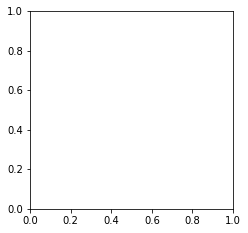

In [45]:
#analyzing the individual errors
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [46]:
from sklearn.neighbors import KNeighborsClassifier #example of each instance assigned to multiple class(outputs multiple binary tags is called multilabel classification)
y_train_large = (y_train >= 7) # the valus which greter than 6 from 0 to 9 digits
y_train_odd = (y_train%2==1)   # which is odd 
y_multilabel = np.c_[y_train_large, y_train_odd] #y_multilabel containing two target labels for each digit
knn_clf = KNeighborsClassifier() #defind knn_clf means kNeighbors classifier
knn_clf.fit(X_train,y_multilabel)  # X, y = mnist["data"], mnist["target"], mnist is the totall dataset
knn_clf.predict([some_digit]) # here some_digit means 5, which is not greater than 7(false) and odd(true)

array([[False,  True]])

In [ ]:
#To evaluate a multilabel classifier one approach is to measure the F1 score for each individual label and coumpute the average score.
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3) #Cross val predict:takes the model used on the data,the input and target data as well as a 'cv' argument and returns the predicted values for each input.
f1_score(y_multilabel,y_train_knn_pred,average="macro") #To evaluate a multilabel classifier one approach is to measure the F1 score for each individual label and coumpute the average score.

In [48]:
#multioutput classification: it is a generalization of multilabel classification where each label can be multiclass
#Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s randint() function.
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
#Now let’s train the classifier and make it clean this image:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_digit]])
plot_digit(clean_digit)

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
#generate some linear looking data to test Normal equation
from matplotlib import pyplot as plt
import numpy as np
X = 2*np.random.rand(100,1) # generate X,y for Normal equation
y = 4+3*X+ np.random.rand(100,1) #the equation is y=4+ 3X1 + Gaussian noise
plt.plot(X,y)
plt.xlabel('X1')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

In [ ]:
#let's compute theta using normal equation,use inv() function using np.linalg to compute the inverse of a matrix
X_b = np.c_[np.ones((100,1)),X] #add x0=1 to each instance, np.ones(row,col)
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T.dot(y)) #here "." declares the power
#the actual equation is y=4+ 3X1 + Gaussian noise, normal eqn is 0=inv((X*pow(T)*X))*(X*pow(T))*y
theta_best #here we find the value We would have hoped for θ0 = 4 and θ1 = 3 instead of θ0 = 4.215 and θ1 = 2.770. Close enough, but the noise made it impossible to recover the exact parameters of the original function.


In [ ]:
#prediction using 0
X_new = np.array([[0], [2]]) #create array where is one coloumn and two rows, the index are 0th and 2th index
X_new_b = np.c_[np.ones((2, 1)), X_new] # np.ones[row,col] means 2*1 matrix fullfill with one and this value set on X_new variable and stores on X_new_b variable 
y_predict = X_new_b.dot(theta_best) #here multplication previous output with X_new_b(holds one(2*1 matrix)) 
y_predict